# **Machine Problem 4: Feature Extraction and Image Matching in Computer Vision**

**0.1 Connect Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**0.2 Update OpenCV**

In [ ]:
!pip uninstall opencv-python opencv-contrib-python

Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python.libs/libavcodec-9aae324f.so.59.37.100
    /usr/loca

In [ ]:
!apt-get update
!apt-get install -y build-essential cmake git libgtk2.0-dev pkg-config libavcodec-dev libavformat-dev libswscale-dev libtbb2 libtbb-dev libjpeg-dev libpng-dev libtiff-dev libdc1394-22-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,074 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
G

In [ ]:
!git clone https://github.com/opencv/opencv.git
!git clone https://github.com/opencv/opencv_contrib.git

Cloning into 'opencv'...
remote: Enumerating objects: 337512, done.
remote: Counting objects: 100% (734/734), done.
remote: Compressing objects: 100% (574/574), done.
remote: Total 337512 (delta 294), reused 384 (delta 127), pack-reused 336778 (from 1)
Receiving objects: 100% (337512/337512), 528.11 MiB | 21.04 MiB/s, done.
Resolving deltas: 100% (235415/235415), done.
Updating files: 100% (7566/7566), done.
Cloning into 'opencv_contrib'...
remote: Enumerating objects: 41718, done.
remote: Counting objects: 100% (1468/1468), done.
remote: Compressing objects: 100% (1062/1062), done.
remote: Total 41718 (delta 559), reused 985 (delta 323), pack-reused 40250 (from 1)
Receiving objects: 100% (41718/41718), 150.26 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (25670/25670), done.


In [ ]:
import os
os.makedirs('opencv/build', exist_ok=True)
os.chdir('opencv/build')

!cmake -D CMAKE_BUILD_TYPE=Release \
       -D CMAKE_INSTALL_PREFIX=/usr/local \
       -D OPENCV_EXTRA_MODULES_PATH=../../opencv_contrib/modules \
       -D OPENCV_ENABLE_NONFREE=ON \
       ..

!make -j$(nproc)
!make install


-- The CXX compiler identification is GNU 11.4.0
-- The C compiler identification is GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detected processor: x86_64
-- Found PythonInterp: /usr/bin/python3 (found suitable version "3.10.12", minimum required is "3.2")
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.10.so (found suitable exact version "3.10.12")
-- Looking for ccache - not found
-- Performing Test HAVE_CXX_FSIGNED_CHAR
-- Performing Test HAVE_CXX_FSIGNED_CHAR - Success
-- Performing Test HAVE_C_FSIGNED_CHAR
-- Performing Test HAVE_C_FSIGNED_CHAR - Success
-- Performing Test HAVE_CXX_W
-- Performing 

**0.3 Importing Libraries**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd
from skimage.feature import hog

**0.4 Initializing Functions**

In [ ]:
def harris_corner_detection(image_path):
    #Load Image
    image = cv2.imread(image_path)

    #Convert Image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dst = cv2.cornerHarris(gray_image, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    image[dst > 0.01 * dst.max()] = [0, 0, 255]
    return image

def hog_feature_extraction(image_path):
    #Load Image
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(gray_image,
                        orientations=8,
                        pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1),
                        visualize=True)

    return hog_image

def orb_feature_matching(image_path1, image_path2):
    #Load Image
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    #Conver Image to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create()

    #Find the keypoints and descriptors with ORB
    keypoints_flann1, descriptors_flann1 = orb.detectAndCompute(gray_image1, None)
    keypoints_flann2, descriptors_flann2 = orb.detectAndCompute(gray_image2, None)

    #FLANN parameters for ORB
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=1)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    #Match descriptors using KNN
    f_matches = flann.knnMatch(descriptors_flann1, descriptors_flann2, k=2)

    #Apply Lowe's ratio test to filter out poor matches
    good_matches = []
    for match in f_matches:
        if len(match) == 2:
            m, n = match
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

    #Draw only the good matches
    flann_image = cv2.drawMatches(image1, keypoints_flann1, image2, keypoints_flann2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return flann_image

def sift_and_surf_feature_extraction(image_path1, image_path2):
    #Load images
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    #Convert to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    surf = cv2.xfeatures2d.SURF_create()

    #Detect keypoints and compute descriptors using SIFT
    keypoints_sift1, descriptors_sift1 = sift.detectAndCompute(gray_image1, None)
    keypoints_sift2, descriptors_sift2 = sift.detectAndCompute(gray_image2, None)

    #Detect keypoints and compute descriptors using SURF
    keypoints_surf1, descriptors_surf1 = surf.detectAndCompute(gray_image1, None)
    keypoints_surf2, descriptors_surf2 = surf.detectAndCompute(gray_image2, None)

    #Draw keypoints on images
    sift_image1 = cv2.drawKeypoints(image1, keypoints_sift1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    sift_image2 = cv2.drawKeypoints(image2, keypoints_sift2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    surf_image1 = cv2.drawKeypoints(image1, keypoints_surf1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    surf_image2 = cv2.drawKeypoints(image2, keypoints_surf2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return sift_image1, sift_image2, surf_image1, surf_image2

def plot_sift_surf(sift_image1, sift_image2, surf_image1, surf_image2):
    #Plot the images in a 2x2 grid
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(sift_image1, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("SIFT Keypoints - Image 1")

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(sift_image2, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("SIFT Keypoints - Image 2")

    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(surf_image1, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("SURF Keypoints - Image 1")

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(surf_image2, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("SURF Keypoints - Image 2")

    plt.tight_layout()
    plt.show()

def brute_force_feature_matching(image_path1, image_path2):
    #Load images
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    #Convert to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    #Initialize ORB detector
    orb = cv2.ORB_create()

    #Detect keypoints and compute descriptors
    keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

    #Initialize Brute-Force matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    #Match descriptors
    matches = bf.match(descriptors1, descriptors2)

    #Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    #Draw the top 20 matches
    image_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:20], None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return image_matches

def watershed_segmentation(image_path):
    #Load image
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Apply thresholding
    _, thresholded_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

    #Noise removal with morphological opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel, iterations=2)

    #Identify sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    #Identify sure foreground area using distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    #Identify unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    #Marker labeling
    _, markers = cv2.connectedComponents(sure_fg)

    #Adjust markers so background is 1 and unknown regions are 0
    markers = markers + 1
    markers[unknown == 255] = 0

    #Apply the watershed algorithm
    markers = cv2.watershed(image, markers)

    #Mark boundaries with red
    image[markers == -1] = [0, 0, 255]

    return image


## **Task 1: Harris Corner Detection**

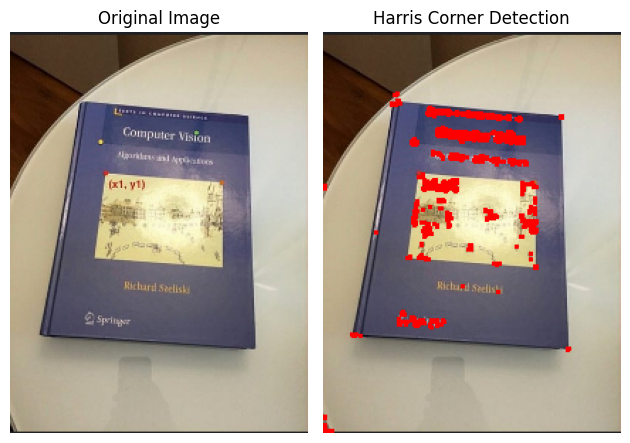

In [ ]:
#Load Image
image1_harris = '/content/drive/MyDrive/image11_2.png'
orig_harris = cv2.imread(image1_harris)

#Apply Harris corner detection
apply_harris = harris_corner_detection(image1_harris)

#Plot the image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig_harris, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(apply_harris, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Harris Corner Detection")

plt.tight_layout()
plt.show()


## **Task 2: HOG Feature Extraction**

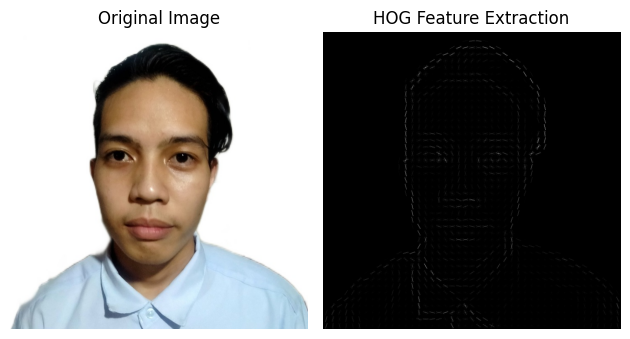

In [ ]:
#Load images
image1_hog = '/content/drive/MyDrive/photo.jpg'
orig_hog = cv2.imread(image1_hog)

#Apply Hog feature extraction
apply_hog = hog_feature_extraction(image1_hog)

#Plot the image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig_hog, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(apply_hog, cmap='gray')
plt.axis("off")
plt.title("HOG Feature Extraction")

plt.tight_layout()
plt.show()


## **Task 3: ORB Feature Extraction and Matching**

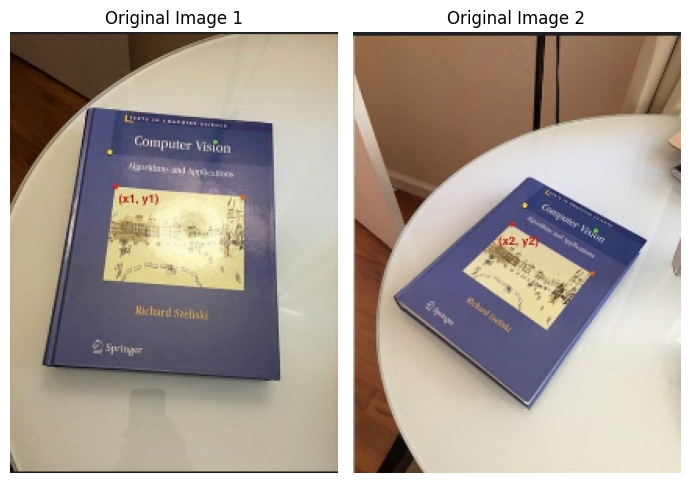

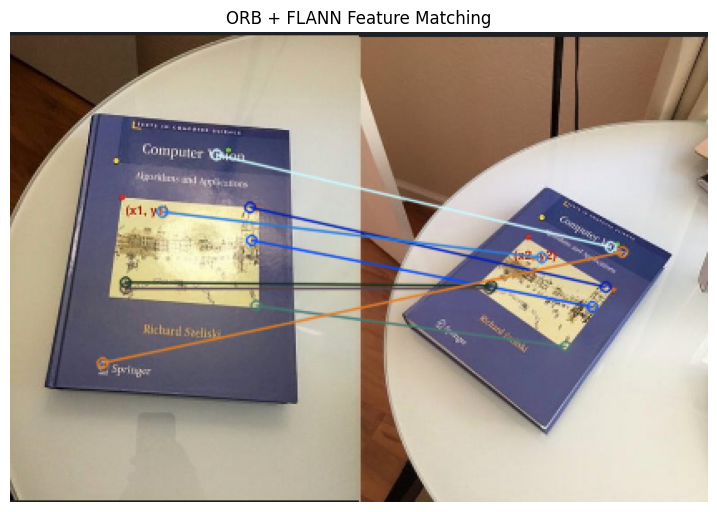

In [ ]:
#Load Images
image1_orb_flann = '/content/drive/MyDrive/image11_2.png'
image2_orb_flann = '/content/drive/MyDrive/image11_3.png'
orig1_orb_flann = cv2.imread(image1_orb_flann)
orig2_orb_flann = cv2.imread(image2_orb_flann)

#Apply ORB and FLANN Feature Matching
apply_orb_flan = orb_feature_matching(image1_orb_flann, image2_orb_flann)

#Plot the image
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig1_orb_flann, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image 1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(orig2_orb_flann, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image 2")

plt.tight_layout()

plt.figure(figsize=(9, 8))
plt.imshow(cv2.cvtColor(apply_orb_flan, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('ORB + FLANN Feature Matching')
plt.show()


## **Task 4: SIFT and SURF Feature Extraction**

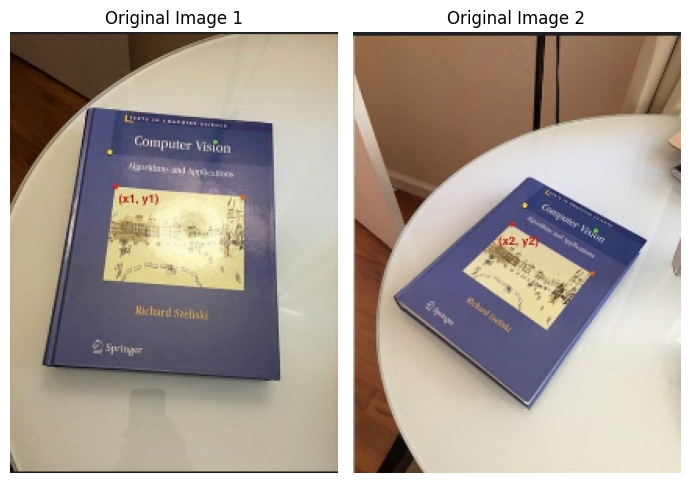

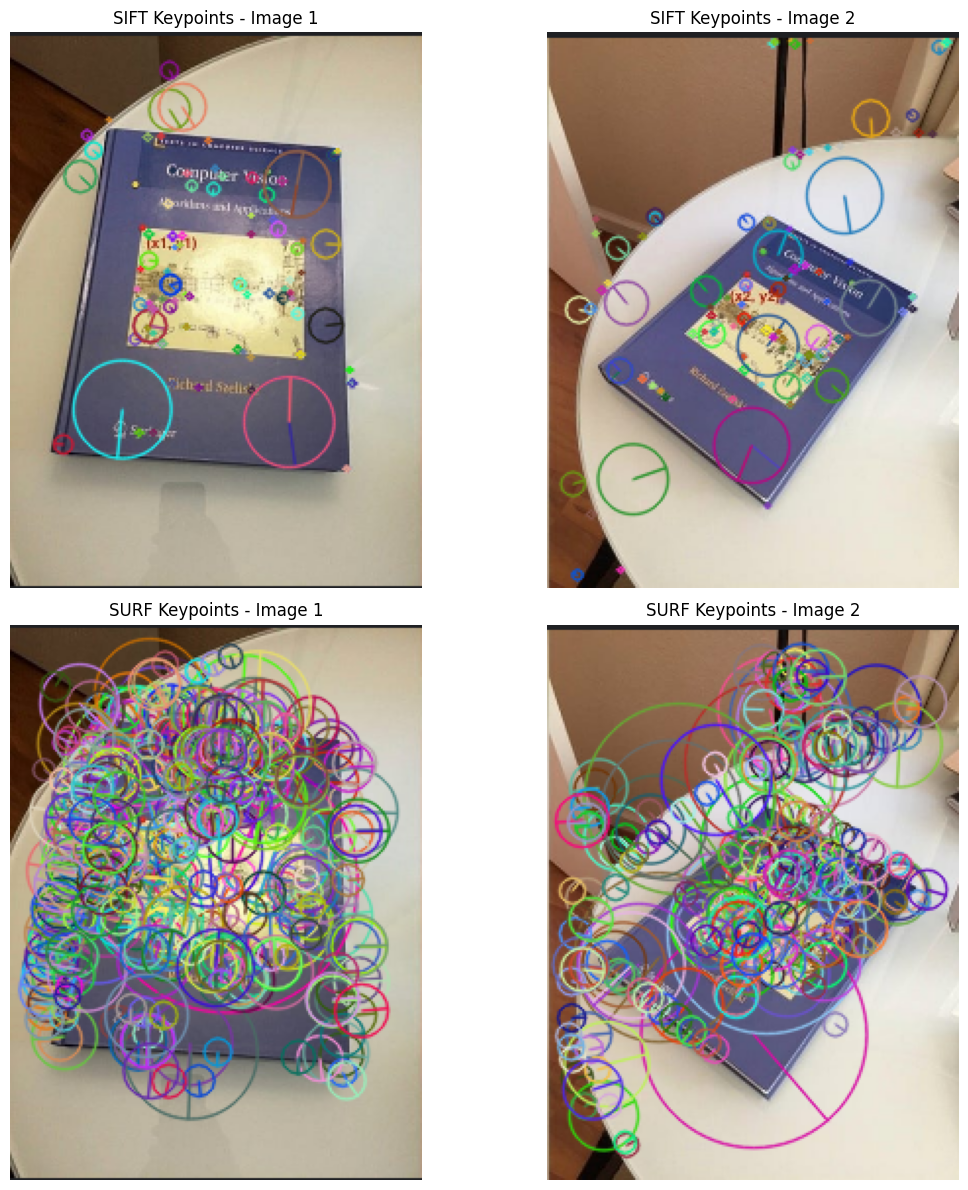

In [ ]:
#Load Images
image1_sift_surf = '/content/drive/MyDrive/image11_2.png'
image2_sift_surf = '/content/drive/MyDrive/image11_3.png'
orig1_sift_surf = cv2.imread(image1_sift_surf)
orig2_sift_surf = cv2.imread(image2_sift_surf)

#Plot the images
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig1_sift_surf, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image 1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(orig2_sift_surf, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image 2")

plt.tight_layout()
plt.show()

#Apply SIFT and SURF
apply_sift_surf = sift_and_surf_feature_extraction(image1_sift_surf, image2_sift_surf)

#Plot the images
plot_sift_surf(apply_sift_surf[0], apply_sift_surf[1], apply_sift_surf[2], apply_sift_surf[3])

## **Task 5: Feature Matching Using Brute Force**

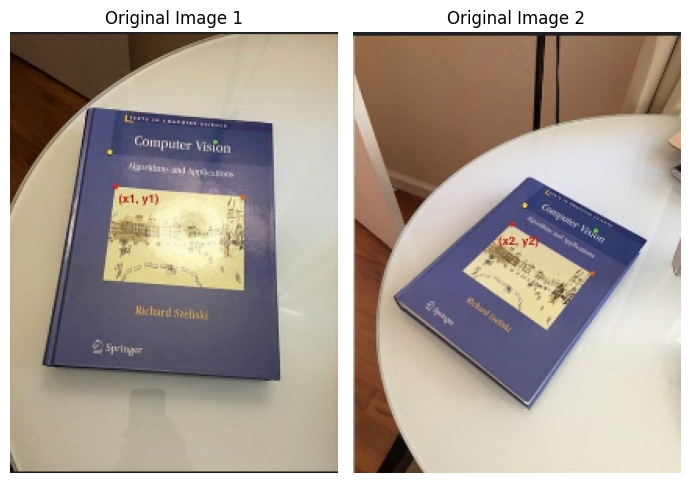

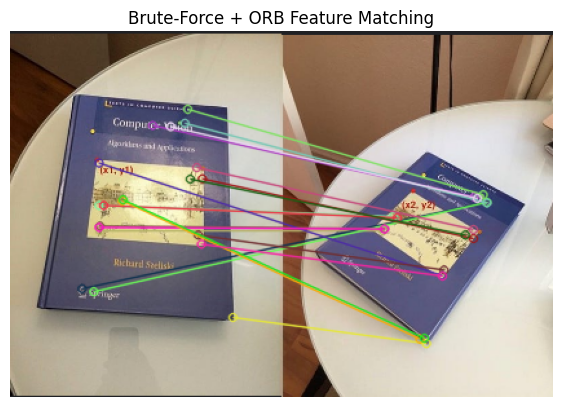

In [ ]:
#Load Images
image1_bf_orb = '/content/drive/MyDrive/image11_2.png'
image2_bf_orb = '/content/drive/MyDrive/image11_3.png'
orig1_bf_orb = cv2.imread(image1_bf_orb)
orig2_bf_orb = cv2.imread(image2_bf_orb)

#Applt Feature Mathing BF
apply_bf_orb = brute_force_feature_matching(image1_bf_orb, image2_bf_orb)

#Piot the image
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig1_bf_orb, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image 1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(orig2_bf_orb, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image 2")

plt.tight_layout()

plt.figure(figsize=(7, 5))
plt.imshow(cv2.cvtColor(apply_bf_orb, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Brute-Force + ORB Feature Matching')
plt.show()

## **Task 6: Image Segmentation using Watershed**

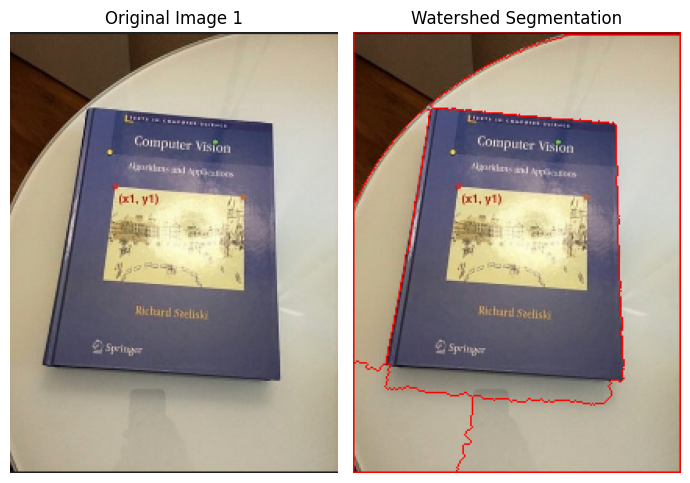

In [ ]:
#Load Images
image1_watershed = '/content/drive/MyDrive/image11_2.png'
orig_watershed = cv2.imread(image1_watershed)

#Apply watershed Algorithm
apply_watershed = watershed_segmentation(image1_watershed)

#Plot the images
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig_watershed, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Image 1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(apply_watershed, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Watershed Segmentation")

plt.tight_layout()

